In [ ]:
# default_exp sparse.sparsify_callback

# SparsifyCallback

> Use the sparsifier in fastai Callback system

In [ ]:
#all_slow

In [ ]:
#hide
from nbdev.showdoc import *

%config InlineBackend.figure_format = 'retina'

In [ ]:
#export
from fastai.vision.all import *
from fastai.callback.all import *
from fasterai.sparse.sparsifier import *
from fasterai.sparse.criteria import *

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

def label_func(f): return f[0].isupper()

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(64))

In [ ]:
#export
class SparsifyCallback(Callback):
        
    def __init__(self, end_sparsity, granularity, method, criteria, sched_func, start_sparsity=0, start_epoch=0, lth=False, rewind_epoch=0, reset_end=False):
        store_attr()
        self.current_sparsity, self.previous_sparsity = 0, 0

        assert self.start_epoch>=self.rewind_epoch, 'You must rewind to an epoch before the start of the pruning process'
    
    def before_fit(self):
        print(f'Pruning of {self.granularity} until a sparsity of {self.end_sparsity}%')
        self.sparsifier = Sparsifier(self.learn.model, self.granularity, self.method, self.criteria)
        self.n_batches = math.floor(len(self.learn.dls.dataset)/self.learn.dls.bs)
        self.total_iters = self.n_epoch * self.n_batches
        self.start_iter = self.start_epoch * self.n_batches
    
    def before_epoch(self):
        if self.epoch == self.rewind_epoch:
            print(f'Saving Weights at epoch {self.epoch}')
            self.sparsifier._save_weights()
        
    def before_batch(self):
        if self.epoch>=self.start_epoch:
            self._set_sparsity()
            self.sparsifier.prune(self.current_sparsity)

            if self.lth and self.current_sparsity!=self.previous_sparsity: # If sparsity has changed, the network has been pruned
                    print(f'Resetting Weights to their epoch {self.rewind_epoch} values')
                    self.sparsifier._reset_weights()

            self.previous_sparsity = self.current_sparsity
        
    def before_step(self):
        if self.epoch>=self.start_epoch:
            self.sparsifier.mask_grad()
            
    def after_epoch(self):
        print(f'Sparsity at the end of epoch {self.epoch}: {self.current_sparsity:.2f}%')
        
        
    def after_fit(self):
        print(f'Final Sparsity: {self.current_sparsity:.2f}')
        if self.reset_end:
            self.sparsifier._reset_weights()
        self.sparsifier._clean_buffers() # Remove buffers at the end of training
        

    def _set_sparsity(self):
        self.current_sparsity = self.sched_func(start=self.start_sparsity, end=self.end_sparsity, pos=(self.train_iter-self.start_iter)/(self.total_iters-self.start_iter))

The most important part of our `Callback` happens in `before_batch`. There, we first compute the sparsity of our network according to our schedule and then we remove the parameters accordingly.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.685760,1.191403,0.826116,00:08
1,0.409567,0.314207,0.881597,00:09
2,0.219406,0.222819,0.913396,00:08


In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

You can use any scheduling function already [available](https://docs.fast.ai/callback.schedule.html#Annealing) in fastai or come up with your own ! 

Here is for example how to implement the [Automated Gradual Pruning](https://arxiv.org/pdf/1710.01878.pdf) schedule.

In [ ]:
def sched_agp(start, end, pos): return end + start - end * (1 - pos)**3

In [ ]:
sp_cb = SparsifyCallback(end_sparsity=50, granularity='weight', method='local', criteria=l1_norm, sched_func=sched_agp)

In [ ]:
learn.fit_one_cycle(3, cbs=sp_cb)

Pruning of weight until a sparsity of 50%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.613291,0.440225,0.863329,00:11
1,0.326938,0.215635,0.907984,00:11
2,0.176516,0.203821,0.924222,00:11


Sparsity at the end of epoch 0: 35.19%
Sparsity at the end of epoch 1: 48.15%
Sparsity at the end of epoch 2: 50.00%
Final Sparsity: 50.00


Surprisinlgy, our network that is composed of $50 \%$ of zeroes performs reasonnably well when compared to our plain and dense network.

When pruning a neural network, there are 3 main schedules that are used:

- **One-Shot Pruning:** starting from a trained network, prune the network to desired sparsity and fine-tune it.
- **Iterative Pruning:** starting from a trained network, alternate pruning and fine-tuning steps until desired sparsity.
- **Gradual Pruning:** inject the pruning operation directly in the training process.

While those methods have for a long time thought to be very different, all of them can be grouped an applied in the same way... with a fastai Callback ! 

In [ ]:
def sched_it(start, end, pos, n_steps=3):
    "Perform iterative pruning, and pruning in `n_steps` steps"
    return start + ((end-start)/n_steps)*(np.ceil((pos)*n_steps))
    
def sched_os(start, end, pos)->float: return end

As One-Shot and Iterative Pruning usually start from an already trained network, we need to take that possibility into account. This can be done by using the `start_epoch` argument, which sets the `epoch` at which we start to prune the network.

Let's take an example here. Let's say that we want to train our network for 3 epochs without pruning and then 7 epochs with pruning.

In [ ]:
# Those value below represent the percentage of the pruning process
train = np.zeros(300)
prune = np.linspace(0,1, 700) 

In [ ]:
#hide
os = [one_shot(0,50, p) for p in prune]

NameError: name 'prune' is not defined

Then this is what our different pruning schedules will look like:

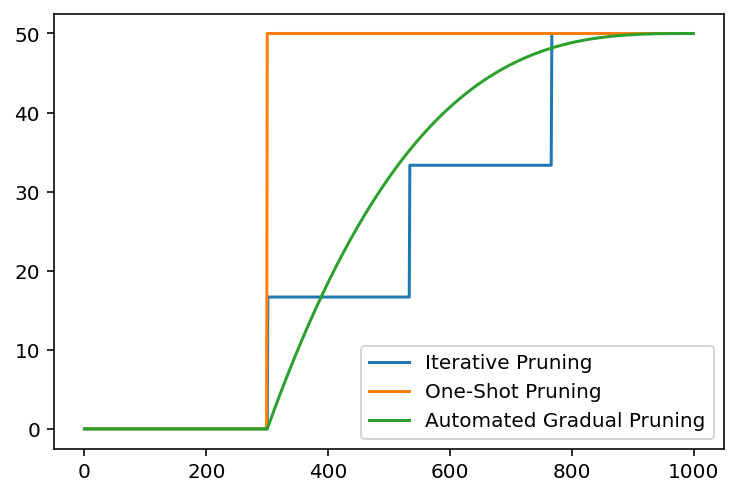

In [ ]:
plt.plot(np.concatenate([train, sched_it(0,50, prune)]), label='Iterative Pruning')
plt.plot(np.concatenate([train, os]), label='One-Shot Pruning')
plt.plot(np.concatenate([train, sched_agp(0,50, prune)]), label='Automated Gradual Pruning')
plt.legend()